# The Newman-Ziff algorithm

Site (or bond) percolation involves testing every node (or edge) in a network to "occupy" is with some probability $\phi$, thereby giving rise to a largest, "giant" connected component or GCC. We are however almost certainly *not* interested in the size of the GCC for *one specific value* of $\phi$, but rather want to know how the size of the GCC changes as $\phi$ changes -- *i.e.*, as more nodes or edges are occupied. If we wanted to explore the behaviour of the system over, for example, 100 values of $\phi$, we would need to perform 100 percolation experiments, each of which involves touching every node and edge in the network. We need not do the computational complexioty calculation to realise that this would be prohibitively expensive, and actually it's a lot worse than we might think.

The [Newman-Ziff algorithm](#NZ00) is a clever way to perform site (or bond) percolation at *all* values of $\phi$ in a single sweep through the network. The important observation here is that occupying a single node (or a single edge) can connect together two existing components. This actually immediately leads to another problem, which is identifying which component a node is part of and possibly changing that component as it merges with others as the percolation process progresses. This is an example of a **union-find algorithm**, which can be extremely expensive in themselves: one might imagine that combining two large clusters would involve relabelling all the nodes in one of them, and again it doesn't take much to see that this will become prohibitive if done frequently, as would be the case in the final stages of giant component formation.

Newman-Ziff avoids this problem by using of trees of nodes to represent clusters. The root of a component tree "labels" it. Combining two clusters simply involves attaching the root of one tree to some element of the other, so that both trees now have the same root (and hence the same "label"). A few extra bits of cleverness allow us to represent all the component trees within a single array of size $N$, *and* to record the size of each component at the root node to make the computation of GCC size simply a matter of lookup.

In [1]:
from epyc import ParallelLab, Experiment, LabNotebook, HDF5LabNotebook
from epydemic import BondPercolation, SitePercolation, PLCNetwork

# maths
from math import exp
from mpmath import polylog

# display and interaction
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context('notebook', font_scale=0.75)

In [2]:
# create a persistent notebook for the results
nb = HDF5LabNotebook('datasets/newman-ziff-percolation.h5', description='Newman-Ziff percolation experiments')

We will run the experiments locally, optionally using multiple cores to run several experiments simultaneously.

In [3]:
lab = ParallelLab(notebook=nb, cores=8) #only 3 cores get used, one per cutoff

## Site percolation

We will reproduce figure 13 of [[NZ00]](#NZ00). This computes the site percolation behaviour on a network of $10^6$ nodes with a powerlaw-with-cutoff degree distribution, for three different cutoff values $\kappa$.

The computation involves running the site percolation experiment over networks with different cutoff values. 

In [7]:
if not nb.already('site-percolation-plc', description="Site percolation on powerlaw-with-cutoff networks for various cutoffs"):
    # metadata for this experiment
    rs = nb.current()
    rs[PLCNetwork.N] = 'Network order'
    rs[PLCNetwork.EXPONENT] = 'Powerlaw exponent'
    rs[PLCNetwork.CUTOFF] = 'Powerlaw cutoff'
    rs[SitePercolation.P] = 'Occupation probability'
    rs[SitePercolation.GCC] = 'Size of giant connected component (GCC)'

    # set up the network parameter space
    lab[PLCNetwork.N] = int(1e6)
    lab[PLCNetwork.EXPONENT] = 2.5
    lab[PLCNetwork.CUTOFF] = [20, 50, 100]

    # run the experiment over the parameter space
    e = SitePercolation(PLCNetwork())
    lab.runExperiment(e)

The time-consuming part of this experiment is creating the million-node networks to experiment on: as shown below, the actual experimental time is short.

In [8]:
df = nb.select('site-percolation-plc').dataframe()

We need to compare these results with the known theoretical predictions for percolation. Calloway *et alia* [[CNSW00]](#CNSW00) derived the necessary equations for the size $S$ of the giant component at a specific value of $\phi$ in terms of the degree distribution $p_k$ and a value $u$ which is defined in terms of a self-consistency equation:

$$
    S = q - q \sum_{k=0}^{\infty} p_k u^k \qquad \qquad u = 1 - q - q \frac{\sum_{k=0}^{\infty} k p_k u^{k - 1}}{\sum_{k=0}^{\infty}k p_k}
$$

We first need the degree distribution $p_k$. which for a powerlaw-with-cutoff network is given by:

$$
    p_k = \frac{1}{C} k^{-\alpha} e^{-k / \kappa}
$$

where $C = Li_\alpha(e^{-1 / \kappa})$ is a constant of proportionality derived from the polylogarithm function. We can code this distribution very simply.

In [10]:
def make_PLC(alpha, kappa):
    '''Create a powerlaw-with-cutoff probability distribution for the given parameters.
    
    :param alpha: the exponent
    :param kappa: the cutoff'''
    C = polylog(alpha, exp(-1.0 / kappa))
    def p(k):
        return (pow(k, -alpha) * exp(-k / kappa)) / C
    return p

Given this we can then code $S$ and $u$. Note that the definition of $u$ also takes a value of $u$ as an argument, giving rise to a self-consistency condition.

In [11]:
def S(u, p, phi, maxk=100):
    s = 0
    for k in range(1, maxk):
        s += p(k) * pow(u, k)
    return phi * (1 - s)

def u(u, p, phi, maxk=100):
    s = 0
    t = 0
    for k in range(1, maxk):
        s += k * p(k) * pow(u, k - 1)
        t += k * p(k)
    return 1 - phi + phi * s / t

We can then compute the theoretical size of the GCC by first computing $u$ using fixed-point iteration and using this to find $S$.

In [12]:
def fpi(f, x=0.0, delta=1e-6, maxreps=50):
    '''Perform naive fixed-point iteration on the given function.
    
    :param f: the function (of one variable)
    :param x: (optional) the starting point (defaults to 0.0)
    :param delta: (optional) the stopping distance (defauls to 1e-6)
    :param maxreps: (optional) maximum number of steps (defaults to 50)
    :returns: the converged value of x'''
    for _ in range(maxreps):
        xprime = f(x)
        if abs(x - xprime) < delta:
            return xprime
        x = xprime
    return x

def gcc_theoretical(p, phi):
    '''Compute the theoretical size of the giant connected comoponent.
    
    :param p: the degree distribution
    :param phi: the occupation probability
    :returns: the predicted size of the GCC as a fraction of the network size'''
    u_fix = fpi(lambda x: u(x, p, phi))
    return S(u_fix, p, phi)

From this we can plot the theoertical curves for GCC size against the experimental results.

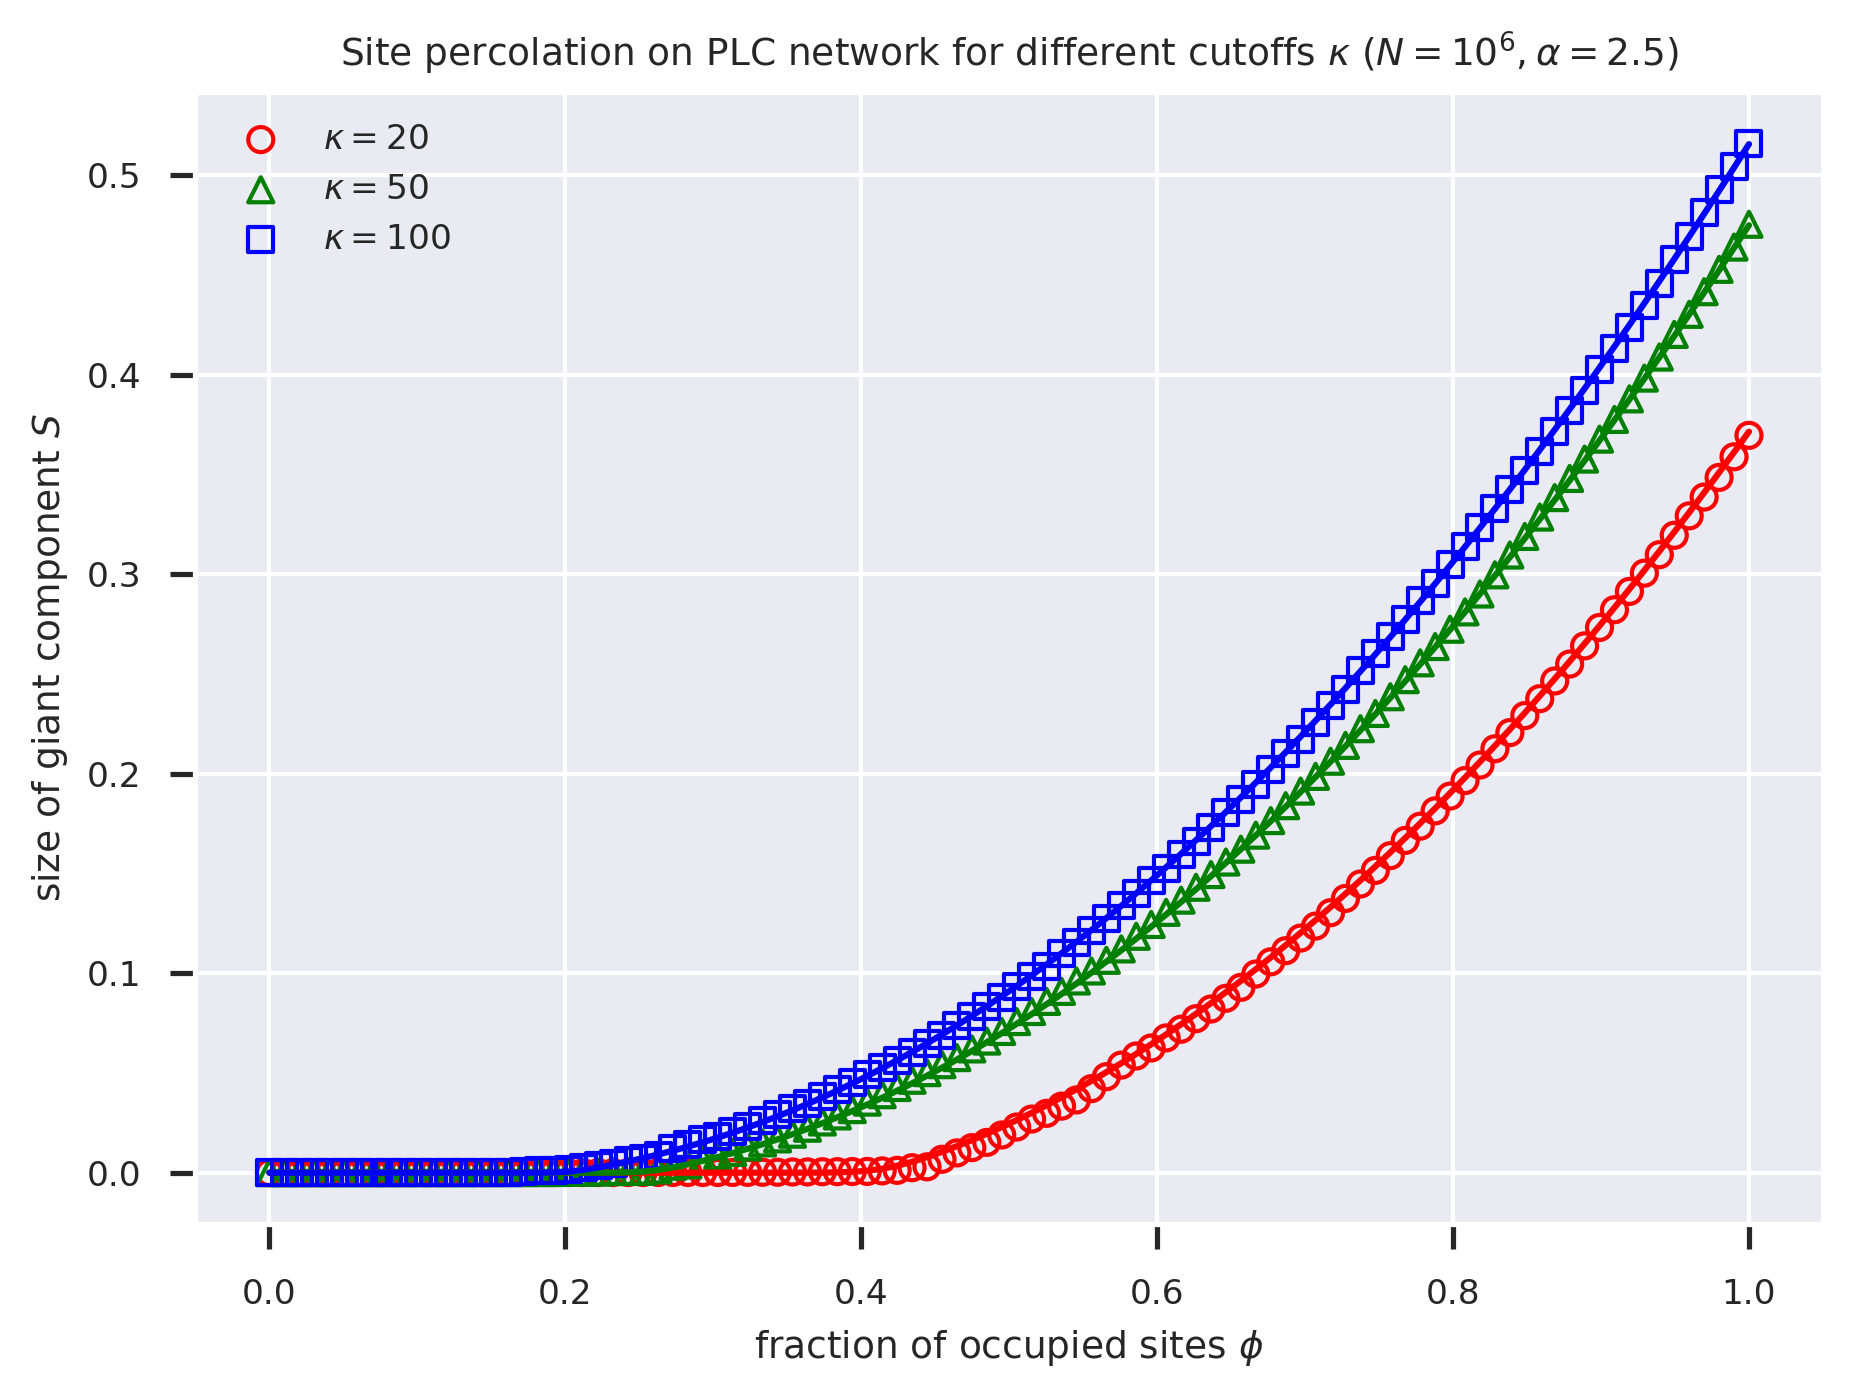

In [13]:
kappas = sorted(df[PLCNetwork.CUTOFF].unique())

fig = plt.figure(figsize=(7,5))
kappa_colours = ['r', 'g', 'b']
kappa_markers = ['o', '^', 's']

gccs = dict()
for i in range(len(kappas)):
    kappa = kappas[i]
    kdf = df[df[PLCNetwork.CUTOFF] == kappa]
    
    # theory
    p = make_PLC(2.5, kappa)
    gccs[kappa] = list(map(lambda phi: gcc_theoretical(p, phi) if phi > 0.0 else 0.0, kdf[SitePercolation.P]))
    plt.plot(kdf[SitePercolation.P], gccs[kappa], '{c}-'.format(c=kappa_colours[i]))
    
    # experiment
    plt.scatter(kdf[SitePercolation.P], kdf[SitePercolation.GCC] / 1e6, color='none', edgecolors=kappa_colours[i], marker=kappa_markers[i], label='$\kappa = {k}$'.format(k=kappa))

plt.xlabel('fraction of occupied sites $\phi$')
plt.ylabel('size of giant component $S$')
plt.legend(loc='upper left')
plt.title('Site percolation on PLC network for different cutoffs $\kappa$ ($N = 10^6, \\alpha = 2.5$)')

plt.savefig('site-percolation-plc.png')
_ = plt.show()

How long does the process take?

In [14]:
for kappa in kappas:
    kdf = df[df[PLCNetwork.CUTOFF] == kappa]
    gen = kdf[Experiment.SETUP_TIME].mean()
    per = kdf[Experiment.EXPERIMENT_TIME].mean()
    print('kappa = {k}, network creation {c}s, percolation process {p}s'.format(k=kappa, c=int(gen), p=int(per)))

kappa = 20, network creation 1855s, percolation process 6s
kappa = 50, network creation 1872s, percolation process 7s
kappa = 100, network creation 1886s, percolation process 8s


Newman and Ziff comment that generating the above plot took "about an hour in total". For comparison -- 20 years later, and coded in Python rather than C -- the three processes in the above figure take under half a minute to compute -- *if* we ignore network-creation time, which takes half an hour for each cutoff. (It actually takes longer to numerically approximate the curves of the theoretical model than it does to run the experiment.)

## References

<a id='CNSW00'>[CNSW00]</a> Duncan Callaway, M.E.J. Newman, Steven Strogatz, and Duncan Watts. [Network robustness and fragility: Percolation on random graphs](https://doi.org/10.1103/PhysRevLett.85.5468). Physical Review Letters **85**. 2000.

<a id='NZ00'>[NZ00]</a> M.E.J. Newman and R.M. Ziff. [Efficient Monte Carlo algorithm and high-precision results for percolation](https://doi.org/10.1103/PhysRevLett.85.4104>). Physical Review Letters **85**. November 2000.
